## Covid Morbidity Factors Exploration Project
### Chris Weilacker, Kirk Kosinski, Patrick Cao, OJ Alcaraz
### 9 February 2021

#### Datasets are orginally from the following:

##### COVID-19 Case Mortality Ratios by Country

https://www.kaggle.com/paultimothymooney/coronavirus-covid19-mortality-rate-by-country

##### Percentage of Population 65 and Over by Country (2019)

https://www.kaggle.com/krukmat/demographic-and-socioeconomic-unesco

##### Percentage of Obesity among Adults by Country (2016)
https://www.kaggle.com/amanarora/obesity-among-adults-by-country-19752016

##### Life Expectancy at Birth(HALE) by Country (2019)
https://www.kaggle.com/utkarshxy/who-worldhealth-statistics-2020-complete


### Problem Question: Can we create a model that can predict the risk for the Case Mortality Ratio of a Country utilizing its Life Expectancy, Percentage of Population over 65, and Percentage of Obesity?

#### We decided on using Population Over Age 65 and Obesity because in the US, over 80% of the deaths were in the population 65 and over, and the CDC has stated that 94% of deaths had some underlying health condition.  We also used Life Expectency per country to account for possible deficiencies in the health care system. John Hopkins University has listed several diseases such as heart disease and Diabetes which are known to be exacerbated by Obesity. Our idea is that we can more accurately predict the Mortality Ratio of COVID-19 by using both population 65 and over and Obesity rather than just population 65 and over. This may show that creating a healthier population is the best way to prevent the devastation in future pandemics that the US is currently facing.

### On the following slide we will run some Data Preprocessing to get all of our data in one Data Frame df.

In [19]:
import numpy as np
import pandas as pd
from matplotlib import rcParams
import seaborn as sns
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# allow output to span multiple output lines in the console
pd.set_option('display.max_columns', 500)

# switch to seaborn default stylistic parameters
# see the very useful https://seaborn.pydata.org/tutorial/aesthetics.html
sns.set()
sns.set_context('talk')

# change default plot size
rcParams['figure.figsize'] = 10,8
# Covid Data
covidDF = pd.read_csv('https://raw.githubusercontent.com/chrisweilacker/CovidMachineLearningProject/master/global_covid19_mortality_rates.csv', index_col=0)
# 2016 Data for Both Sexes is in Column Both Sexes
obesityDF = pd.read_csv('https://raw.githubusercontent.com/chrisweilacker/CovidMachineLearningProject/master/obesity-data.csv', skiprows=3)
# Demographics Data which includes the percentage of population over 65 per country.
demoDF = pd.read_csv('https://raw.githubusercontent.com/chrisweilacker/CovidMachineLearningProject/master/DEMO_Global.csv')
# Life Expectancy at Birth Data
lifeDF = pd.read_csv('https://raw.githubusercontent.com/chrisweilacker/CovidMachineLearningProject/master/HALElifeExpectancyAtBirth.csv')

lifeDF.rename(columns={'Location': 'Country', 'First Tooltip': 'Life_Expectancy'}, inplace=True)

# Create our DataFrame with the necessary data from all three datasets
df = covidDF.merge(obesityDF[['Country', 'Both sexes']], how='inner') #Copy in the whole Covid Data and the Obesity Data
# Modify name of Both Sexes to Obesity and get just the number
df.rename(columns={'Both sexes': 'Obesity'}, inplace=True)
obNumber = df['Obesity'].str.split(" ", n = 1, expand = True) 
df['Obesity'] = obNumber[0]

#Drop Rows with no Obesity Data
df.drop(df.loc[df['Obesity']=='No'].index, inplace=True)
#Drop Rows with no Covid Data
df.drop(df.loc[df['Mortality Ratio']==0].index, inplace=True)
df.rename(columns={'Mortality Ratio': 'Covid-19 Mortality Ratio'}, inplace=True)
# Convert Obesity data to float
df['Obesity'] = pd.to_numeric(df['Obesity'], downcast="float")

df.drop(df.loc[df['Country']=='Yemen'].index,inplace=True)

# Get the Pop 65 and Over and Tot Pop Data to Calculate Percent 65 and Over
df = df.merge(demoDF[['Country', 'Value']][(demoDF['Time']==2017) & (demoDF['Indicator']=='Population aged 65 years or older ')], how='inner') #Copy in the 65 and Over Data
df.rename(columns={'Value': 'Pop65Over'}, inplace=True)
df = df.merge(demoDF[['Country', 'Value']][(demoDF['Time']==2017) & (demoDF['Indicator']=='Total population ')], how='inner') #Copy in the 65 and Over Data
df.rename(columns={'Value': 'TotPop'}, inplace=True)

# Add In Life Expectancy Data
df = df.merge(lifeDF[['Country', 'Life_Expectancy']][(lifeDF['Period']==2019) & (lifeDF['Dim1']=='Both sexes')])

# Create Perc 65 and Over
df['Perc65Over'] = (100 * df['Pop65Over']/df['TotPop'])

corr = df[['Covid-19 Mortality Ratio', 'Perc65Over', 'Obesity', 'Life_Expectancy']].corr()
#It seems that there is a correlation between both Perc 65 and Over, Obesity and Covid-19 Mortality Ratio
#Though the Perc65 and Over seems to be stronger than Obesity, but the data hasnt been normalized yet.
#We may later want to bring in another dimension such as functionality of the countries health system
# depending on what the ML algorithm can do.


# We might need to create a categorical column for mortality whether it is high risk or not
# and see if an ML algorithm such as KNN can use the obesity and Over 65 Population to 
# categorize the data would be more accurate. We used the normalization of the Mortality-Ratio with
# all mortality ratio's above one standard deviation as being considered High Risk.

df['HighRisk'] = zscore(df['Covid-19 Mortality Ratio']) > 1
df['NormCovid19Mortality'] = zscore(df['Covid-19 Mortality Ratio'])

corr.style.background_gradient(cmap='coolwarm')

,Covid-19 Mortality Ratio,Perc65Over,Obesity,Life_Expectancy
Covid-19 Mortality Ratio,1.000000,0.282377,0.073821,0.131760
Perc65Over,0.282377,1.000000,0.382824,0.727345
Obesity,0.073821,0.382824,1.000000,0.570750
Life_Expectancy,0.131760,0.727345,0.570750,1.000000


### Data Visualizations

_The following are Data Visualizations for Life Expectancy, Perc65Over and Obesity with regards to Covid-19 Mortality Ratio's which is simply the percentage of deaths per confirmed case._

<AxesSubplot:xlabel='Perc65Over', ylabel='Obesity'>

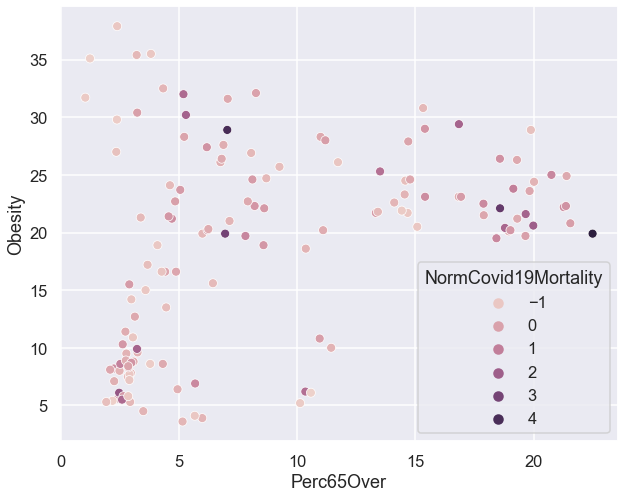

In [20]:
sns.scatterplot(data=df, x='Perc65Over', y='Obesity', hue='NormCovid19Mortality')

<AxesSubplot:xlabel='Perc65Over', ylabel='Obesity'>

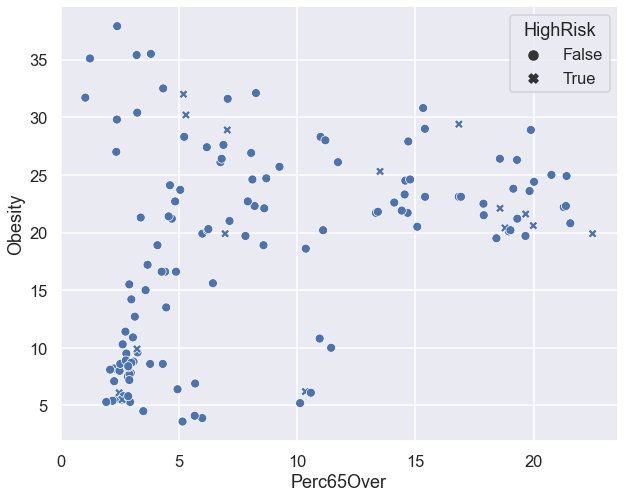

In [21]:
sns.scatterplot(data=df, x='Perc65Over', y='Obesity', style='HighRisk')


<AxesSubplot:xlabel='Life_Expectancy', ylabel='Obesity'>

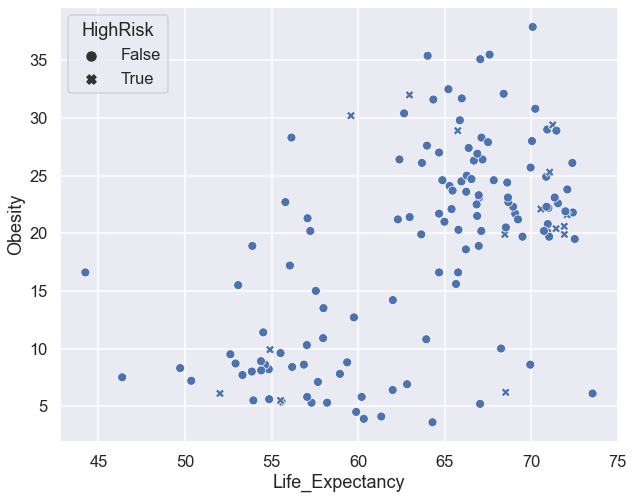

In [22]:
sns.scatterplot(data=df, x='Life_Expectancy', y='Obesity', style='HighRisk')


_After viewing the graphs we are concerned about the accuracy that ML algorithms can achieve with this data. The data may improve as more accurate case data is produced from Antibody testing.  We will continue and see if our ML Algorithm can do better than we are expecting. We have initially chosen to use categorization with the HighRisk category as that may be more accurate than regression._

### Now we will split our data for the Machine Learning Algorithm using the High Risk Category as our target and Life_Expectancy,  Obesity, and Perc65andOver as features

In [24]:
# select the predictor variables and target variables to be used with categorization
predictors = ['Life_Expectancy', 'Obesity', 'Perc65Over']
target = 'HighRisk'
X = df[predictors].values
y = df[target].values

# Split the data into training and test sets, and scale
scaler = StandardScaler()

# unscaled version (note that scaling is only used on predictor variables)
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# scaled version
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)